In [53]:
import IPython
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys ; sys.path.append('../')
from model.network_architecture import autoencoder
from tqdm import tqdm
from evaluacion import *
import soundfile as sf

In [28]:
clean_list = get_audio_list('/home/martin/deep-dereverb/data/test/clean/')
reverb_list = get_audio_list('/home/martin/deep-dereverb/data/test/real/')
clean_list.sort(); reverb_list.sort()
reverb, _ = librosa.load(reverb_list[0], sr=None)
clean, _ = librosa.load(clean_list[0], sr=None) 

In [44]:
stft_reverb = librosa.stft(reverb, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
mag_reverb = np.abs(stft_reverb)
pha_reverb = np.angle(stft_reverb)

stft_clean = librosa.stft(clean, n_fft=512, hop_length=128)#[:-1,:]# Descarto altas frecuencias
mag_clean = np.abs(stft_clean)
pha_clean = np.angle(stft_clean)

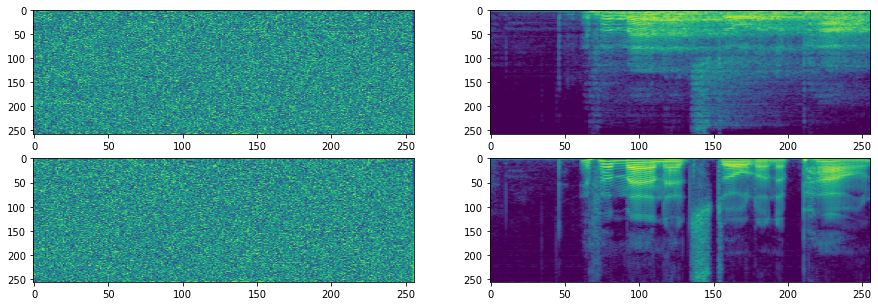

In [47]:
plt.figure(1, figsize=(15,5))
plt.subplot(2,2,1)
plt.imshow(pha_reverb, aspect='auto')
plt.subplot(2,2,2)
plt.imshow(librosa.amplitude_to_db(mag_reverb), aspect='auto')
plt.subplot(2,2,3)
plt.imshow(pha_clean, aspect='auto')
plt.subplot(2,2,4)
plt.imshow(librosa.amplitude_to_db(mag_clean), aspect='auto');plt.show()

In [71]:
print('Audio original')
stft_build = mag_clean * np.exp(1j*pha_clean)
recover = librosa.istft(stft_build, hop_length=128, win_length=512)
sf.write('fase/referencia.wav',recover,16000)
IPython.display.Audio(recover, rate=16000)

Audio original


In [72]:
print('Reconstruccion fase reverberante')
stft_build = mag_clean * np.exp(1j*pha_reverb)
recover_r = librosa.istft(stft_build, hop_length=128, win_length=512)
sf.write('fase/opcion1(elcorrecto).wav',recover_r,16000)
IPython.display.Audio(recover_r, rate=16000)

Reconstruccion fase reverberante


In [73]:
print('Reconstruccion griffin-lim')
recover_gf = librosa.griffinlim(mag_clean,n_iter=500,hop_length=128,win_length=512)
IPython.display.Audio(recover_gf, rate=16000)
sf.write('fase/opcion2.wav',recover_gf,16000)
IPython.display.Audio(recover_r, rate=16000)

Reconstruccion griffin-lim


In [76]:
print('Reconstruccion griffin-lim')
recover_gf = librosa.griffinlim(mag_clean,n_iter=100,hop_length=128,win_length=512)
IPython.display.Audio(recover_gf, rate=16000)
sf.write('fase/opcion3.wav',recover_gf,16000)
IPython.display.Audio(recover_r, rate=16000)

Reconstruccion griffin-lim


In [ ]:
def gen_stft(audio):
    #Genero las STFT
    stft_ = librosa.stft(audio, n_fft=512, hop_length=128)[:-1,:]# Descarto altas frecuencias
    stft_ = np.abs(stft_)
    #Escala logaritmica
    log_stft_ = librosa.amplitude_to_db(stft_)

    #Normalizacion
    norm_stft_, arr_min, arr_max = normalise(log_stft_)
    return norm_stft_, arr_min, arr_max
